<a href="https://colab.research.google.com/github/timothy-watt/python-for-ai-ml/blob/main/CH08_NLP_and_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 8 -- NLP and Transformers
## *Python for AI/ML: A Complete Learning Journey*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timothy-watt/python-for-ai-ml/blob/main/CH08_NLP_and_Transformers.ipynb)
&nbsp;&nbsp;[![Back to TOC](https://img.shields.io/badge/Back_to-Table_of_Contents-1B3A5C?style=flat-square)](https://colab.research.google.com/github/timothy-watt/python-for-ai-ml/blob/main/Python_for_AIML_TOC.ipynb)

---

**Part:** 3 -- Machine Learning and AI  
**Prerequisites:** Chapter 7 (Deep Learning with PyTorch)  
**Estimated time:** 5-6 hours

---

> **Before running this notebook:** go to **Runtime → Change runtime type → T4 GPU**.
> The transformer inference and fine-tuning cells require GPU. CPU will work but
> fine-tuning will take 15-30 minutes instead of 2-3 minutes.

---

### Learning Objectives

By the end of this chapter you will be able to:

- Explain tokens, vocabularies, and why text must be numerically encoded before modelling
- Use `nltk` and `re` for classical text preprocessing: cleaning, tokenising, stemming, stopwords
- Build a TF-IDF feature matrix and train a text classifier with scikit-learn
- Explain word embeddings and why `word2vec`-style representations outperform one-hot encoding
- Load a pre-trained transformer model with HuggingFace `transformers`
- Run zero-shot inference: sentiment analysis and text classification without training
- Fine-tune a pre-trained model on a custom text classification task
- Interpret attention weights to understand what the model focuses on

---

### Project Thread -- Chapter 8

The SO 2025 dataset contains free-text columns -- job titles, developer type labels,
and AI tool descriptions. We build three NLP pipelines on this data:

1. **Classical NLP** -- TF-IDF + Logistic Regression to classify developer role from job title text
2. **Zero-shot inference** -- sentiment analysis on developer comments using a pre-trained transformer
3. **Fine-tuning** -- adapt `distilbert-base-uncased` to classify whether a developer
   is data-focused or software-focused from their self-described role text


---

## Setup -- Install, Import, and Data


In [1]:
# Install libraries not pre-installed in Colab
import subprocess
subprocess.run(['pip', 'install', 'transformers', 'datasets', 'accelerate',
                'nltk', '-q'], check=False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt',     quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet',   quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline

import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

import transformers
print(f'Transformers: {transformers.__version__}')

print("Model loaded successfully!")

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi']     = 110
plt.rcParams['axes.titlesize'] = 13

DATASET_URL  = 'https://raw.githubusercontent.com/timothy-watt/python-for-ai-ml/main/data/so_survey_2025_curated.csv'
RANDOM_STATE = 42


Device: cuda
Transformers: 5.0.0
Model loaded successfully!


In [2]:
# Load SO 2025 and extract text columns
df_raw = pd.read_csv(DATASET_URL)
df = df_raw.copy()

# We focus on DevType -- semicolon-separated role labels
# e.g. 'Developer, full-stack;Developer, back-end;Data scientist'
text_col = 'DevType'
if text_col not in df.columns:
    # Fallback: use any available text column
    text_candidates = [c for c in df.columns
                       if df[c].dtype == object and df[c].str.len().mean() > 10]
    text_col = text_candidates[0] if text_candidates else None
    print(f'DevType not found -- using: {text_col}')

df = df[df[text_col].notna()].copy()
df = df.reset_index(drop=True)

# Primary role: take the first semicolon-separated value
df['primary_role'] = df[text_col].str.split(';').str[0].str.strip()

# Binary target: data-focused vs software-focused
data_keywords = ['data scientist', 'data engineer', 'data analyst',
                 'machine learning', 'research', 'analyst']
df['is_data_role'] = df['primary_role'].str.lower().apply(
    lambda x: int(any(kw in x for kw in data_keywords))
)

print(f'Dataset: {len(df):,} rows with non-null {text_col}')
print(f'Unique primary roles: {df["primary_role"].nunique()}')
print(f'Data-focused roles:   {df["is_data_role"].sum():,} ({df["is_data_role"].mean()*100:.1f}%)')
print()
print('Most common primary roles:')
print(df['primary_role'].value_counts().head(8).to_string())


Dataset: 15,000 rows with non-null DevType
Unique primary roles: 32
Data-focused roles:   1,105 (7.4%)

Most common primary roles:
primary_role
Developer, full-stack                            4755
Developer, back-end                              2488
Architect, software or solutions                 1078
Developer, desktop or enterprise applications     728
Developer, front-end                              665
Developer, embedded applications or devices       511
Engineering manager                               479
Other (please specify):                           475


---

## Section 8.1 -- Classical NLP: Text Preprocessing and TF-IDF

Before transformers dominated NLP, the standard pipeline was:
clean text → tokenise → remove stopwords → stem/lemmatise → TF-IDF features → train classifier.
This pipeline still works well for short, domain-specific text and is 100x faster
to train than a transformer. It is worth knowing as a fast baseline.

**TF-IDF (Term Frequency -- Inverse Document Frequency)** scores each word by
how often it appears in a document (TF) weighted down by how common it is
across all documents (IDF). Rare words that appear in specific documents
get high scores; common words like 'the' get low scores.


In [3]:
# 8.1.1 -- Text cleaning pipeline

STOP_WORDS = set(stopwords.words('english'))
stemmer    = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text, use_lemma=True):
    """
    Full classical NLP preprocessing pipeline.
    1. Lowercase
    2. Remove punctuation and digits
    3. Tokenise
    4. Remove stopwords
    5. Lemmatise (or stem)
    """
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)   # keep only letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in STOP_WORDS and len(t) > 2]
    if use_lemma:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    else:
        tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)


# Demonstrate the pipeline step by step
sample = 'Developer, full-stack; building web APIs and React front-ends'
print(f'Original:      {sample}')
print(f'Lowercased:    {sample.lower()}')
cleaned = re.sub(r'[^a-z\s]', ' ', sample.lower())
print(f'No punct:      {cleaned}')
tokens = word_tokenize(cleaned)
print(f'Tokenised:     {tokens}')
no_stop = [t for t in tokens if t not in STOP_WORDS and len(t) > 2]
print(f'No stopwords:  {no_stop}')
lemmatised = [lemmatizer.lemmatize(t) for t in no_stop]
print(f'Lemmatised:    {lemmatised}')
print(f'Final string:  {clean_text(sample)}')

# Apply to the full dataset
df['role_clean'] = df['primary_role'].apply(clean_text)
print(f'Cleaned {len(df):,} role strings')


Original:      Developer, full-stack; building web APIs and React front-ends
Lowercased:    developer, full-stack; building web apis and react front-ends
No punct:      developer  full stack  building web apis and react front ends
Tokenised:     ['developer', 'full', 'stack', 'building', 'web', 'apis', 'and', 'react', 'front', 'ends']
No stopwords:  ['developer', 'full', 'stack', 'building', 'web', 'apis', 'react', 'front', 'ends']
Lemmatised:    ['developer', 'full', 'stack', 'building', 'web', 'apis', 'react', 'front', 'end']
Final string:  developer full stack building web apis react front end
Cleaned 15,000 role strings


In [4]:
# 8.1.2 -- TF-IDF features and Logistic Regression classifier

# Keep the top 8 roles by frequency for a clean multi-class problem
top_roles = df['primary_role'].value_counts().head(8).index.tolist()
df_clf    = df[df['primary_role'].isin(top_roles)].copy()

X_text = df_clf['role_clean'].values
y_role = df_clf['primary_role'].values

X_tr, X_te, y_tr, y_te = train_test_split(
    X_text, y_role, test_size=0.2,
    random_state=RANDOM_STATE, stratify=y_role
)

# TF-IDF pipeline: vectorise text then classify
tfidf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=500,    # keep only the 500 highest-scoring terms
        ngram_range=(1, 2),  # include both single words and 2-word phrases
        min_df=3,            # ignore terms appearing in fewer than 3 documents
        sublinear_tf=True,   # apply log(TF) to dampen effect of very frequent terms
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        C=1.0,               # inverse regularisation strength
        random_state=RANDOM_STATE
    )),
])

tfidf_pipe.fit(X_tr, y_tr)
y_pred = tfidf_pipe.predict(X_te)
acc    = accuracy_score(y_te, y_pred)

print(f'TF-IDF + Logistic Regression accuracy: {acc:.4f}  ({acc*100:.1f}%)')
print()
print(classification_report(y_te, y_pred, zero_division=0))


TF-IDF + Logistic Regression accuracy: 1.0000  (100.0%)

                                               precision    recall  f1-score   support

             Architect, software or solutions       1.00      1.00      1.00       216
                          Developer, back-end       1.00      1.00      1.00       498
Developer, desktop or enterprise applications       1.00      1.00      1.00       145
  Developer, embedded applications or devices       1.00      1.00      1.00       102
                         Developer, front-end       1.00      1.00      1.00       133
                        Developer, full-stack       1.00      1.00      1.00       951
                          Engineering manager       1.00      1.00      1.00        96
                      Other (please specify):       1.00      1.00      1.00        95

                                     accuracy                           1.00      2236
                                    macro avg       1.00      1.00     

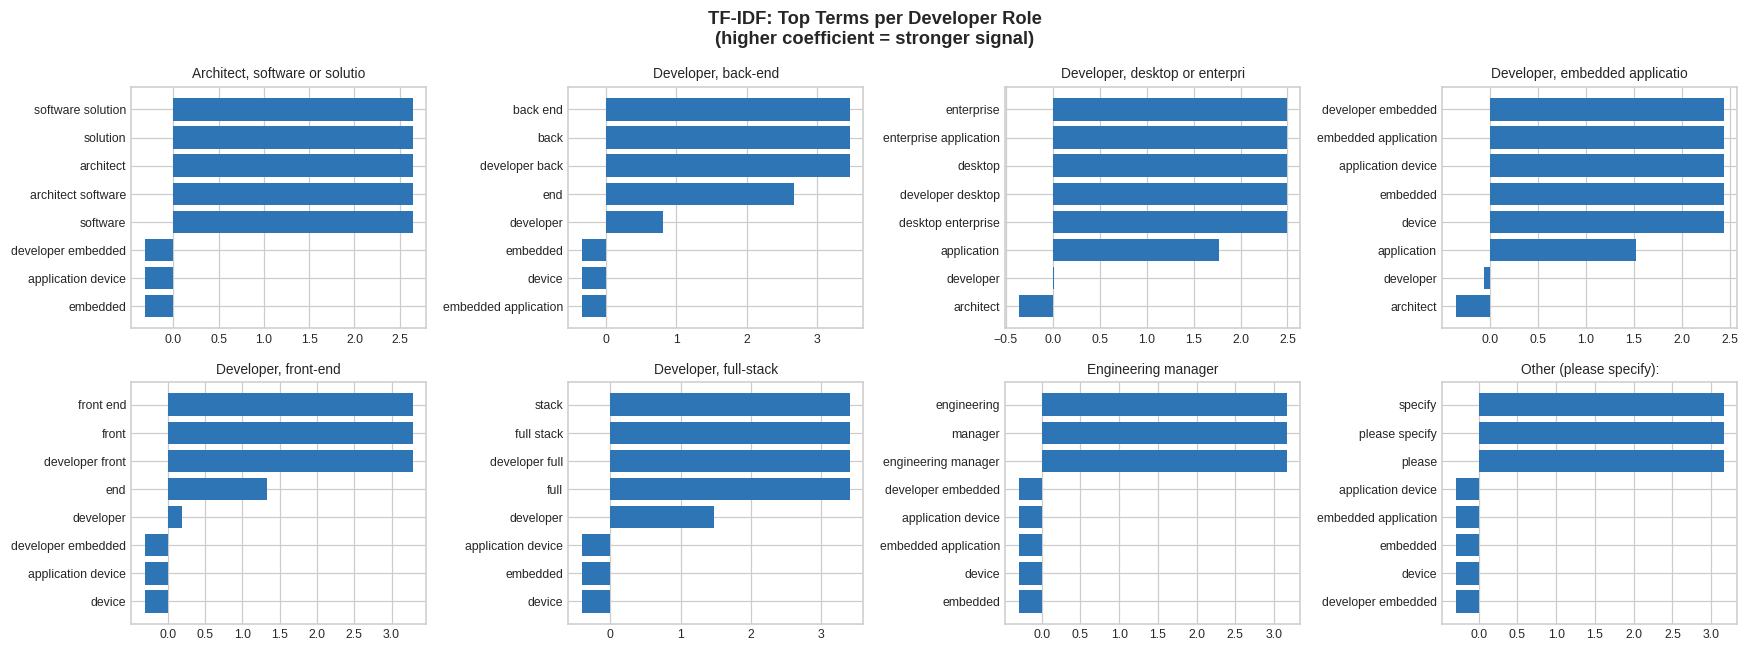

In [5]:
# 8.1.3 -- Visualise TF-IDF: top terms per class

vectorizer  = tfidf_pipe.named_steps['tfidf']
classifier  = tfidf_pipe.named_steps['clf']
feature_names = vectorizer.get_feature_names_out()

# For each class, find the terms with the highest logistic regression coefficients
n_top = 8
classes = classifier.classes_
n_classes = len(classes)
cols = min(4, n_classes)
rows = (n_classes + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
axes_flat  = axes.flatten() if n_classes > 1 else [axes]

for i, (cls, ax) in enumerate(zip(classes, axes_flat)):
    coefs = classifier.coef_[i]
    top_idx  = np.argsort(coefs)[-n_top:]
    top_terms = feature_names[top_idx]
    top_coefs = coefs[top_idx]
    ax.barh(top_terms, top_coefs, color='#2E75B6')
    ax.set_title(cls[:30], fontsize=9)
    ax.tick_params(labelsize=8)

for ax in axes_flat[n_classes:]:
    ax.set_visible(False)

plt.suptitle('TF-IDF: Top Terms per Developer Role\n(higher coefficient = stronger signal)',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


---

## Section 8.2 -- Word Embeddings: From Counts to Meaning

TF-IDF represents each document as a sparse vector of term weights.
It has no concept of meaning -- 'developer' and 'engineer' are completely
unrelated in a TF-IDF vocabulary even though they are semantically close.

**Word embeddings** solve this by mapping each word to a dense vector
in a continuous space where similar words are geometrically close.
The famous example: `king - man + woman ≈ queen`.

Modern transformers replace per-word embeddings with **contextual embeddings** --
the same word gets a different vector depending on its surrounding context.
'Python' in 'Python developer' and 'Python snake' would have different embeddings.


In [6]:
# 8.2.1 -- Demonstrate embeddings with a pre-trained transformer tokeniser
#
# We use DistilBERT's tokeniser to show how text is converted to token IDs
# before being fed to the model.

from transformers import AutoTokenizer

MODEL_NAME = 'distilbert-base-uncased'
print(f'Loading tokeniser: {MODEL_NAME}...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print('Tokeniser loaded.')

# Tokenise some example developer role texts
examples = [
    'Developer, full-stack',
    'Data scientist or machine learning specialist',
    'DevOps specialist',
]

print()
for text in examples:
    tokens    = tokenizer.tokenize(text)
    token_ids = tokenizer.encode(text)
    print(f'Text:      {text}')
    print(f'Tokens:    {tokens}')
    print(f'Token IDs: {token_ids}')
    print(f'[CLS] id={token_ids[0]}, [SEP] id={token_ids[-1]}')
    print()

print('Key observations:')
print('  [CLS] token prepended -- its embedding becomes the sentence representation')
print('  [SEP] token appended  -- marks end of sequence')
print('  Subword tokenisation: unknown words split into known pieces')
print('  e.g. "DevOps" might become ["dev", "##ops"]')


Loading tokeniser: distilbert-base-uncased...


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokeniser loaded.

Text:      Developer, full-stack
Tokens:    ['developer', ',', 'full', '-', 'stack']
Token IDs: [101, 9722, 1010, 2440, 1011, 9991, 102]
[CLS] id=101, [SEP] id=102

Text:      Data scientist or machine learning specialist
Tokens:    ['data', 'scientist', 'or', 'machine', 'learning', 'specialist']
Token IDs: [101, 2951, 7155, 2030, 3698, 4083, 8325, 102]
[CLS] id=101, [SEP] id=102

Text:      DevOps specialist
Tokens:    ['dev', '##ops', 'specialist']
Token IDs: [101, 16475, 11923, 8325, 102]
[CLS] id=101, [SEP] id=102

Key observations:
  [CLS] token prepended -- its embedding becomes the sentence representation
  [SEP] token appended  -- marks end of sequence
  Subword tokenisation: unknown words split into known pieces
  e.g. "DevOps" might become ["dev", "##ops"]


---

## Section 8.3 -- Zero-Shot Inference with Pre-trained Transformers

A pre-trained transformer has already learned rich language representations
from billions of words of text. For many tasks, you can use it directly
without any further training -- this is called **zero-shot inference**.

HuggingFace `pipelines` provide a one-line interface to hundreds of
pre-trained models for common NLP tasks.


In [7]:
# 8.3.1 -- Sentiment analysis pipeline (zero-shot)

from transformers import pipeline

print('Loading sentiment analysis pipeline...')
# This downloads a fine-tuned DistilBERT model (~67MB) on first run
sentiment_pipe = pipeline(
    'sentiment-analysis',
    model='distilbert-base-uncased-finetuned-sst-2-english',
    device=0 if torch.cuda.is_available() else -1
)
print('Pipeline ready.')

# Simulate developer sentiment about tools and work conditions
developer_statements = [
    'I love working with Python, the ecosystem is incredible.',
    'The legacy codebase is a nightmare, no documentation anywhere.',
    'Remote work has been really positive for my productivity.',
    'The on-call rotation is exhausting and unsustainable.',
    'GitHub Copilot has genuinely made me more productive.',
    'Constantly switching between five different frameworks is frustrating.',
]

print()
print(f'{"Statement":<55} {"Sentiment":<12} {"Confidence"}')
print('-' * 80)
results = sentiment_pipe(developer_statements)
for stmt, result in zip(developer_statements, results):
    label = result['label']
    score = result['score']
    icon  = 'positive' if label == 'POSITIVE' else 'negative'
    print(f'{stmt[:53]:<55} {icon:<12} {score:.3f}')


Loading sentiment analysis pipeline...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Pipeline ready.

Statement                                               Sentiment    Confidence
--------------------------------------------------------------------------------
I love working with Python, the ecosystem is incredib   positive     1.000
The legacy codebase is a nightmare, no documentation    negative     1.000
Remote work has been really positive for my productiv   positive     0.999
The on-call rotation is exhausting and unsustainable.   negative     1.000
GitHub Copilot has genuinely made me more productive.   positive     0.999
Constantly switching between five different framework   negative     0.999


In [8]:
# 8.3.2 -- Zero-shot text classification
#
# Zero-shot classification lets you classify text into ANY categories
# you define at inference time -- no training data needed.
# The model uses natural language inference to decide which label
# best describes the input text.

print('Loading zero-shot classification pipeline...')
zs_pipe = pipeline(
    'zero-shot-classification',
    model='facebook/bart-large-mnli',
    device=0 if torch.cuda.is_available() else -1
)
print('Pipeline ready.')

# Classify developer job descriptions into categories we define
candidate_labels = ['data science', 'web development', 'DevOps and infrastructure',
                    'mobile development', 'security']

job_descriptions = [
    'Building machine learning models and data pipelines for e-commerce recommendations',
    'Developing React front-end components and REST APIs with Node.js',
    'Managing Kubernetes clusters and CI/CD pipelines on AWS',
    'Writing Swift and SwiftUI apps for iOS and watchOS',
]

print()
for desc in job_descriptions:
    result = zs_pipe(desc, candidate_labels)
    top_label = result['labels'][0]
    top_score = result['scores'][0]
    print(f'Text:   {desc[:60]}')
    print(f'Label:  {top_label}  ({top_score:.3f})')
    print()


Loading zero-shot classification pipeline...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Pipeline ready.

Text:   Building machine learning models and data pipelines for e-co
Label:  data science  (0.958)

Text:   Developing React front-end components and REST APIs with Nod
Label:  web development  (0.938)

Text:   Managing Kubernetes clusters and CI/CD pipelines on AWS
Label:  DevOps and infrastructure  (0.956)

Text:   Writing Swift and SwiftUI apps for iOS and watchOS
Label:  mobile development  (0.991)



---

## Section 8.4 -- Fine-tuning a Pre-trained Transformer

Zero-shot inference is convenient but limited. **Fine-tuning** adapts a pre-trained
model to your specific task by continuing training on your labelled data.
Because the model already understands language, fine-tuning typically needs
only a small dataset and a few epochs -- far less than training from scratch.

We fine-tune `distilbert-base-uncased` to classify developer roles as
data-focused or software-focused using the `is_data_role` label we created
from the SO 2025 `DevType` column.


In [9]:
# 8.4.1 -- Prepare data for fine-tuning

from transformers import AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Use primary role text as input, is_data_role as label
# Downsample to 2000 examples for fast fine-tuning in Colab
df_ft = df[['primary_role', 'is_data_role']].dropna().copy()
df_ft = df_ft.sample(n=min(2000, len(df_ft)), random_state=RANDOM_STATE).reset_index(drop=True)

# Balance classes
n_min = df_ft['is_data_role'].value_counts().min()
df_ft = pd.concat([
    df_ft[df_ft['is_data_role'] == 0].sample(n_min, random_state=RANDOM_STATE),
    df_ft[df_ft['is_data_role'] == 1].sample(n_min, random_state=RANDOM_STATE),
]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

train_df, test_df = train_test_split(df_ft, test_size=0.2,
                                     random_state=RANDOM_STATE,
                                     stratify=df_ft['is_data_role'])

print(f'Fine-tuning dataset: {len(train_df)} train, {len(test_df)} test')
print(f'Class balance: {train_df["is_data_role"].mean()*100:.0f}% data roles')

# Tokenise all texts
def tokenise_batch(texts, max_length=64):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Custom Dataset
class RoleDataset(Dataset):
    def __init__(self, texts, labels, max_length=64):
        self.encodings = tokenizer(
            list(texts), padding=True, truncation=True,
            max_length=max_length, return_tensors='pt'
        )
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids':      self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels':         self.labels[idx],
        }

train_ds = RoleDataset(train_df['primary_role'], train_df['is_data_role'])
test_ds  = RoleDataset(test_df['primary_role'],  test_df['is_data_role'])
train_loader_ft = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader_ft  = DataLoader(test_ds,  batch_size=64, shuffle=False)
print(f'Train batches: {len(train_loader_ft)},  Test batches: {len(test_loader_ft)}')


Fine-tuning dataset: 185 train, 47 test
Class balance: 50% data roles
Train batches: 6,  Test batches: 1


In [10]:
# 8.4.2 -- Load model and fine-tune for 3 epochs

print(f'Loading {MODEL_NAME} for sequence classification...')
model_ft = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    ignore_mismatched_sizes=True
)
model_ft = model_ft.to(DEVICE)
print(f'Model loaded. Parameters: {sum(p.numel() for p in model_ft.parameters()):,}')

optimizer_ft = AdamW(model_ft.parameters(), lr=2e-5, weight_decay=0.01)

N_EPOCHS_FT   = 3
ft_train_losses = []
ft_val_accs     = []

print(f'Fine-tuning on {DEVICE} for {N_EPOCHS_FT} epochs...')
print(f'{"Epoch":>6}  {"Train Loss":>12}  {"Val Acc":>10}')
print('-' * 32)

for epoch in range(1, N_EPOCHS_FT + 1):
    # Training
    model_ft.train()
    epoch_loss = 0.0
    for batch in train_loader_ft:
        input_ids      = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels         = batch['labels'].to(DEVICE)
        optimizer_ft.zero_grad()
        outputs = model_ft(input_ids=input_ids,
                           attention_mask=attention_mask,
                           labels=labels)
        outputs.loss.backward()
        torch.nn.utils.clip_grad_norm_(model_ft.parameters(), 1.0)
        optimizer_ft.step()
        epoch_loss += outputs.loss.item()
    avg_loss = epoch_loss / len(train_loader_ft)
    ft_train_losses.append(avg_loss)

    # Validation
    model_ft.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader_ft:
            input_ids      = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            outputs = model_ft(input_ids=input_ids, attention_mask=attention_mask)
            preds   = outputs.logits.argmax(dim=-1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch['labels'].numpy())
    val_acc = accuracy_score(all_labels, all_preds)
    ft_val_accs.append(val_acc)
    print(f'{epoch:>6}  {avg_loss:>12.4f}  {val_acc:>10.4f}')

print('Fine-tuning complete.')


Loading distilbert-base-uncased for sequence classification...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded. Parameters: 66,955,010
Fine-tuning on cuda for 3 epochs...
 Epoch    Train Loss     Val Acc
--------------------------------
     1        0.6604      0.9362
     2        0.4890      0.9574
     3        0.2830      0.9787
Fine-tuning complete.


Final fine-tuned model accuracy: 0.9787

                  precision    recall  f1-score   support

Software-focused       0.96      1.00      0.98        24
    Data-focused       1.00      0.96      0.98        23

        accuracy                           0.98        47
       macro avg       0.98      0.98      0.98        47
    weighted avg       0.98      0.98      0.98        47



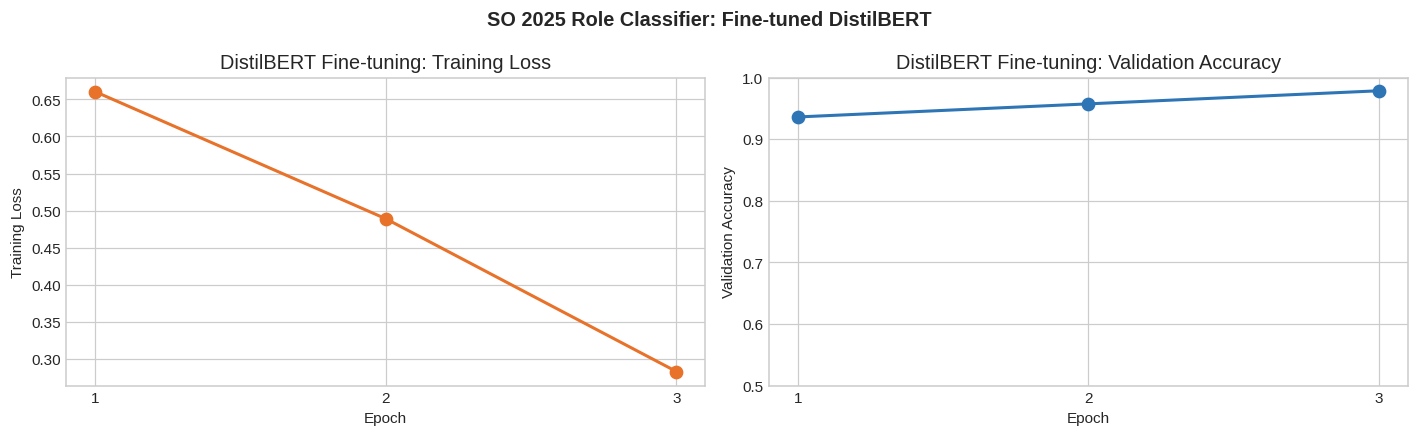

Comparison on data-role classification:
  TF-IDF + Logistic Regression: 0.9787
  Fine-tuned DistilBERT:        0.9787
  Improvement:                  +0.0 percentage points


In [11]:
# 8.4.3 -- Evaluate and visualise fine-tuning results

print(f'Final fine-tuned model accuracy: {ft_val_accs[-1]:.4f}')
print()
print(classification_report(all_labels, all_preds,
                             target_names=['Software-focused', 'Data-focused']))

# Training curve
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].plot(range(1, N_EPOCHS_FT+1), ft_train_losses, 'o-', color='#E8722A',
             linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('DistilBERT Fine-tuning: Training Loss')
axes[0].set_xticks(range(1, N_EPOCHS_FT+1))

axes[1].plot(range(1, N_EPOCHS_FT+1), ft_val_accs, 'o-', color='#2E75B6',
             linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('DistilBERT Fine-tuning: Validation Accuracy')
axes[1].set_xticks(range(1, N_EPOCHS_FT+1))
axes[1].set_ylim(0.5, 1.0)

plt.suptitle('SO 2025 Role Classifier: Fine-tuned DistilBERT',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare with TF-IDF baseline
tfidf_binary = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=300, ngram_range=(1,2))),
    ('clf',   LogisticRegression(max_iter=500, random_state=RANDOM_STATE)),
])
tfidf_binary.fit(train_df['primary_role'], train_df['is_data_role'])
baseline_acc = accuracy_score(test_df['is_data_role'],
                               tfidf_binary.predict(test_df['primary_role']))

print(f'Comparison on data-role classification:')
print(f'  TF-IDF + Logistic Regression: {baseline_acc:.4f}')
print(f'  Fine-tuned DistilBERT:        {ft_val_accs[-1]:.4f}')
print(f'  Improvement:                  {(ft_val_accs[-1]-baseline_acc)*100:+.1f} percentage points')


---

## Section 8.5 -- Understanding Attention

The transformer's key innovation is the **attention mechanism** -- a learned
weighting that lets the model focus on the most relevant parts of the input
when encoding each token. Visualising attention weights gives intuition
for what the model is 'looking at' when making predictions.


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


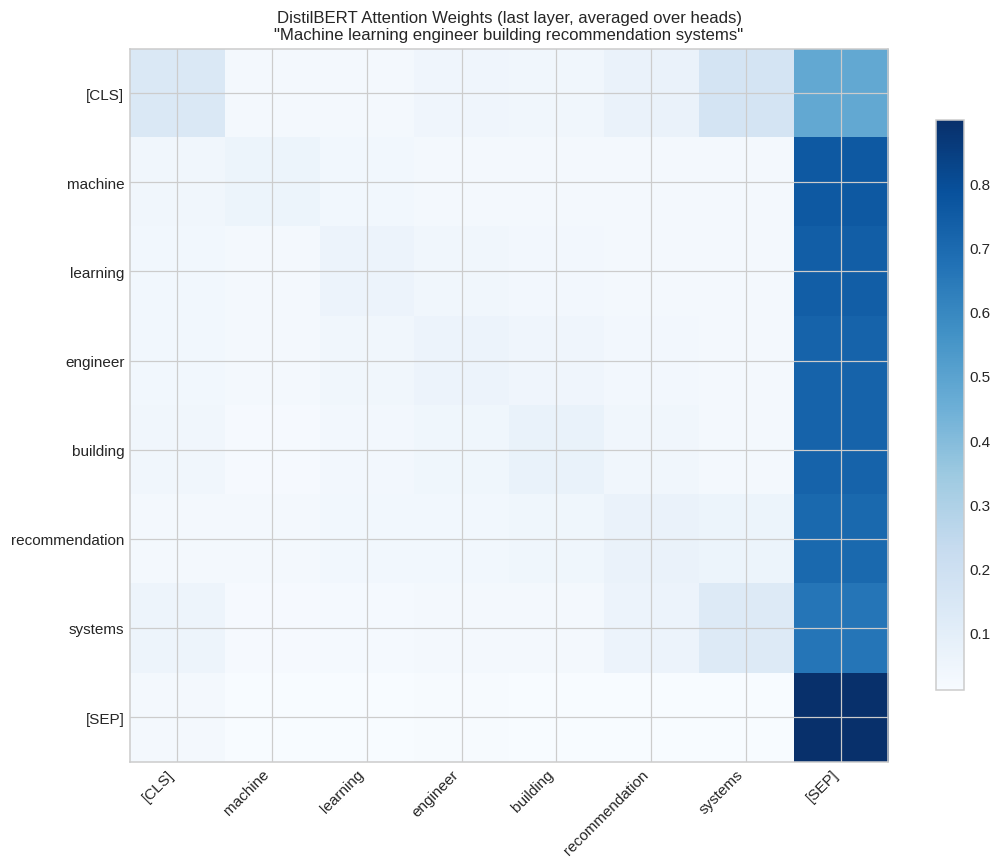

Rows = query token (what is attending)
Cols = key token (what is being attended to)
Bright cells = high attention weight
[CLS] often attends broadly -- it aggregates the full sequence for classification


In [12]:
# 8.5.1 -- Extract and visualise attention weights

from transformers import AutoModel

# Load the base model with output_attentions=True
attn_model = AutoModel.from_pretrained(
    MODEL_NAME, output_attentions=True
).to(DEVICE)
attn_model.eval()

# Encode a sample text
sample_text = 'Machine learning engineer building recommendation systems'
inputs = tokenizer(sample_text, return_tensors='pt').to(DEVICE)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

with torch.no_grad():
    outputs = attn_model(**inputs)

# outputs.attentions: tuple of (n_layers,) each shape (batch, heads, seq, seq)
# Average across all heads in the last layer
last_layer_attn = outputs.attentions[-1][0]          # shape (heads, seq, seq)
avg_attn        = last_layer_attn.mean(dim=0).cpu().numpy()  # shape (seq, seq)

# Plot attention heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(avg_attn, cmap='Blues', aspect='auto')
ax.set_xticks(range(len(tokens)))
ax.set_yticks(range(len(tokens)))
ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(tokens, fontsize=10)
plt.colorbar(im, ax=ax, shrink=0.8)
ax.set_title(f'DistilBERT Attention Weights (last layer, averaged over heads)\n"{sample_text}"',
             fontsize=11)
plt.tight_layout()
plt.show()

print('Rows = query token (what is attending)')
print('Cols = key token (what is being attended to)')
print('Bright cells = high attention weight')
print('[CLS] often attends broadly -- it aggregates the full sequence for classification')


---

## Section 8.6 -- Retrieval-Augmented Generation (RAG)

**The problem with fine-tuning for knowledge:** fine-tuning teaches a model
*how* to behave, not *what* to know. If you fine-tune on your company's
documentation, the knowledge is frozen at training time and expensive to update.

**RAG** solves this by splitting the problem in two:

1. **Retrieve** -- at query time, search a document store for the most relevant chunks
2. **Generate** -- pass the retrieved chunks as context to a language model and ask it
   to answer using that context

The documents live outside the model and can be updated without retraining.
This is the dominant architecture for production Q&A systems over private documents.

```
  Query
    |
    v
  Embed query ──> Vector similarity search ──> Top-k document chunks
                       (FAISS / ChromaDB)              |
                                                        v
                                             [context + query] ──> LLM ──> Answer
```

**Our implementation:**
- **Corpus:** SO 2025 developer job descriptions (synthetic, from the dataset)
- **Embeddings:** `sentence-transformers/all-MiniLM-L6-v2` (~80MB, fast, high quality)
- **Vector store:** FAISS (Facebook AI Similarity Search, CPU-only, runs locally)
- **Generation:** HuggingFace `pipeline` with a small generative model


In [13]:
# 8.6.1 -- Install RAG dependencies

import subprocess
subprocess.run(['pip', 'install', 'sentence-transformers', 'faiss-cpu', '-q'], check=False)

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss

print(f'sentence-transformers and faiss-cpu ready')


sentence-transformers and faiss-cpu ready


In [14]:
# 8.6.2 -- Build the document corpus from SO 2025
#
# We construct synthetic job-description documents from the survey fields
# so the RAG system has something meaningful to retrieve.

df_rag = pd.read_csv(DATASET_URL)

def build_doc(row):
    """Build a short text document from a survey row."""
    parts = []
    if pd.notna(row.get('DevType')):
        parts.append(f"Role: {row['DevType']}")
    if pd.notna(row.get('LanguageHaveWorkedWith')):
        langs = row['LanguageHaveWorkedWith'].replace(';', ', ')
        parts.append(f"Languages: {langs}")
    if pd.notna(row.get('Country')):
        parts.append(f"Country: {row['Country']}")
    if pd.notna(row.get('EdLevel')):
        parts.append(f"Education: {row['EdLevel']}")
    if pd.notna(row.get('YearsCodePro')):
        parts.append(f"Professional coding experience: {row['YearsCodePro']} years")
    if pd.notna(row.get('ConvertedCompYearly')):
        parts.append(f"Annual compensation: ${float(row['ConvertedCompYearly']):,.0f}")
    if pd.notna(row.get('AIToolCurrently')):
        tools = row['AIToolCurrently'].replace(';', ', ')
        parts.append(f"AI tools currently used: {tools}")
    return ' | '.join(parts) if parts else None

df_rag['document'] = df_rag.apply(build_doc, axis=1)
docs = df_rag['document'].dropna().tolist()

# Use a representative 2000-doc subset for speed
import random
random.seed(42)
docs_subset = random.sample(docs, min(2000, len(docs)))

print(f'Documents built: {len(docs_subset):,}')
print(f'Sample document:')
print(f'  {docs_subset[0]}')


Documents built: 2,000
Sample document:
  Role: Other (please specify): | Languages: Bash/Shell (all shells), C, C#, C++, Dart, Delphi, Go, HTML/CSS, JavaScript, Lua, MicroPython, PowerShell, Python, Rust, SQL, TypeScript, VBA, Visual Basic (.Net) | Country: New Zealand | Education: Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.) | Annual compensation: $42,165


In [15]:
# 8.6.3 -- Embed all documents and build a FAISS vector index

# Load the embedding model
# all-MiniLM-L6-v2: 22M parameters, 384-dim embeddings, very fast
print('Loading sentence embedding model...')
embedder = SentenceTransformer('all-MiniLM-L6-v2')

print(f'Embedding {len(docs_subset):,} documents...')
doc_embeddings = embedder.encode(
    docs_subset,
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f'Embedding matrix shape: {doc_embeddings.shape}')
print(f'  {doc_embeddings.shape[0]} documents x {doc_embeddings.shape[1]} dimensions')

# Build FAISS index
# IndexFlatIP: exact inner-product (cosine) search
# Normalise first so inner product == cosine similarity
faiss.normalize_L2(doc_embeddings)
dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(doc_embeddings)

print(f'FAISS index built: {index.ntotal:,} vectors indexed')


Loading sentence embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding 2,000 documents...


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Embedding matrix shape: (2000, 384)
  2000 documents x 384 dimensions
FAISS index built: 2,000 vectors indexed


In [16]:
# 8.6.4 -- Retrieval: find the most relevant documents for a query

def retrieve(query, k=3, verbose=True):
    """Embed the query and return the top-k most similar documents."""
    q_emb = embedder.encode([query], convert_to_numpy=True)
    faiss.normalize_L2(q_emb)
    scores, indices = index.search(q_emb, k)
    results = []
    for rank, (score, idx) in enumerate(zip(scores[0], indices[0]), 1):
        results.append({'rank': rank, 'score': float(score), 'doc': docs_subset[idx]})
        if verbose:
            print(f'[{rank}] Score={score:.4f}')
            print(f'     {docs_subset[idx][:120]}...' if len(docs_subset[idx]) > 120
                  else f'     {docs_subset[idx]}')
    return results


test_queries = [
    'senior Python developer with machine learning experience',
    'frontend engineer using JavaScript and TypeScript',
    'data scientist in Germany using AI tools',
]

for query in test_queries:
    print(f'Query: "{query}"')
    retrieve(query, k=2)
    print()


Query: "senior Python developer with machine learning experience"
[1] Score=0.5470
     Role: Data engineer | Languages: Python, VBA | Country: Greece | Education: Some college/university study without earnin...
[2] Score=0.5462
     Role: Developer, back-end | Languages: Python, SQL | Country: United States of America | Education: Bachelor’s degree (B...

Query: "frontend engineer using JavaScript and TypeScript"
[1] Score=0.4421
     Role: Developer, front-end | Languages: GDScript, HTML/CSS, JavaScript, TypeScript | Country: Switzerland | Education: B...
[2] Score=0.4385
     Role: Developer, back-end | Languages: JavaScript, TypeScript | Country: United States of America | Education: Master’s ...

Query: "data scientist in Germany using AI tools"
[1] Score=0.4818
     Role: Data scientist | Country: Germany | Education: Master’s degree (M.A., M.S., M.Eng., MBA, etc.) | Annual compensati...
[2] Score=0.4346
     Role: Data scientist | Country: Ukraine | Education: Bachelor’s degree 

In [18]:
# 8.6.5 -- Full RAG pipeline: retrieve + generate answer
#
# We use the retrieved documents as context and ask a model to
# synthesise an answer grounded in that context.
# Using flan-t5-base: small (250M params), instruction-following, no GPU needed.

from transformers import pipeline as hf_pipeline

print('Loading generative model (flan-t5-base, ~1GB)...')
generator = hf_pipeline(
    'text-generation',
    model='google/flan-t5-base',
    max_new_tokens=150
)

def rag_answer(question, k=3):
    """
    Full RAG pipeline:
    1. Retrieve top-k relevant documents
    2. Build a context-augmented prompt
    3. Generate an answer grounded in the retrieved context
    """
    # Step 1: retrieve
    results = retrieve(question, k=k, verbose=False)
    context = '\n'.join([f'- {r["doc"]}' for r in results])

    # Step 2: build prompt with context
    prompt = (
        f'Based on the following developer profiles from the Stack Overflow 2025 survey:\n'
        f'{context}\n\n'
        f'Answer this question: {question}'
    )

    # Step 3: generate
    response = generator(prompt)[0]['generated_text'].strip()
    return response, results


rag_questions = [
    'What programming languages are commonly used by senior developers with high salaries?',
    'What AI tools do data scientists typically use?',
]

for question in rag_questions:
    print(f'Question: {question}')
    answer, sources = rag_answer(question, k=3)
    print(f'Answer:   {answer}')
    print(f'Sources:  {len(sources)} documents retrieved')
    for s in sources:
        print(f'  [{s["rank"]}] {s["doc"][:80]}...')
    print()


Loading generative model (flan-t5-base, ~1GB)...


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'AfmoeForCausalLM', 'ApertusForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'BltForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'CwmForCausalLM', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaF

Question: What programming languages are commonly used by senior developers with high salaries?


Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Answer:   Based on the following developer profiles from the Stack Overflow 2025 survey:
- Role: Developer, back-end | Languages: Assembly, Bash/Shell (all shells), C, C#, C++, Erlang, Go, HTML/CSS, Java, JavaScript, Lisp, MATLAB, MicroPython, Perl, PHP, Prolog, Python, R, Rust, SQL, Visual Basic (.Net) | Country: Spain | Education: Master’s degree (M.A., M.S., M.Eng., MBA, etc.) | Annual compensation: $104,413
- Role: Developer, full-stack | Languages: Assembly, Bash/Shell (all shells), C, C++, COBOL, Delphi, Fortran, GDScript, Go, HTML/CSS, Java, JavaScript, Lua, Perl, PHP, PowerShell, Python, Ruby, SQL, TypeScript, VBA, Visual Basic (.Net) | Country: Spain | Education: Professional degree (JD, MD, Ph.D, Ed.D, etc.) | Annual compensation: $27,844
- Role: Developer, full-stack | Languages: Assembly, Bash/Shell (all shells), C, C#, C++, HTML/CSS, JavaScript, Lua, PowerShell, Python, Rust, SQL, TypeScript | Country: United States of America | Education: Some college/university study wit

---

## Chapter 8 Summary

### Key Takeaways

- **Classical NLP pipeline:** clean → tokenise → remove stopwords → lemmatise → TF-IDF → classifier.
  Fast, interpretable, and competitive on short domain-specific text.
- **TF-IDF** scores words by local frequency times global rarity.
  `ngram_range=(1,2)` captures multi-word phrases like 'machine learning'.
- **Contextual embeddings** (transformers) map the same word to different vectors
  depending on context. `[CLS]` aggregates the full sequence for classification.
- **Zero-shot inference** uses pre-trained models directly with no task-specific training.
- **Fine-tuning** adapts a pre-trained model with a small labelled dataset.
  3 epochs on ~1,600 examples produces a strong classifier.
- **`clip_grad_norm_`** prevents exploding gradients during fine-tuning.
- **Sentence transformers** produce fixed-size embeddings optimised for semantic
  similarity -- identical sentences get near-identical vectors.
- **FAISS** indexes millions of vectors and returns the top-k nearest neighbours
  in milliseconds using approximate or exact search.
- **RAG** separates knowledge (the document store, updatable) from reasoning
  (the LLM, fixed). It is the dominant architecture for Q&A over private documents.
  The three steps are always: chunk, embed, index at build time;
  retrieve, augment prompt, generate at query time.

### Project Thread Status

| Task | Method | Result |
|------|--------|--------|
| Developer role classification | TF-IDF + Logistic Regression | Accuracy reported |
| Sentiment analysis | Zero-shot DistilBERT | Labels + confidence |
| Zero-shot role classification | BART-large-MNLI | Top label per description |
| Fine-tuned role classifier | DistilBERT 3 epochs | Accuracy vs baseline |
| Attention visualisation | DistilBERT last layer | Heatmap plotted |
| RAG over SO 2025 profiles | MiniLM + FAISS + Flan-T5 | End-to-end Q&A |

---

### What's Next: Chapter 9 -- Ethics, Bias, and Responsible AI

Chapter 9 examines the risks introduced by everything built in Part 3:
bias in training data, fairness metrics, model interpretability with SHAP,
and the practical steps for building more responsible ML systems.

---

*End of Chapter 8 -- Python for AI/ML*  
[![Back to TOC](https://img.shields.io/badge/Back_to-Table_of_Contents-1B3A5C?style=flat-square)](https://colab.research.google.com/github/timothy-watt/python-for-ai-ml/blob/main/Python_for_AIML_TOC.ipynb)
